# Tutorial: CommonRoad Input-Output
## Reading, Modifying, and Writing CommonRoad Scenarios

This tutorial shows how CommonRoad XML-files can be read, modified, visualized, and stored. To start with, a CommonRoad XML-file consists of a **Scenario** and a **PlanningProblemSet**:
* A **Scenario** represents the environment, which includes a **LaneletNetwork** and a set of **DynamicObstacle** and **StaticObstacle**.
    * A **LaneletNetwork** consists of a set of lane segments (**Lanelets**) that can be connected arbitrarily.
* A **PlanningProblemSet** contains one **PlanningProblem** for every ego vehicle in the **Scenario**, which in turn has an **initial position** and a to-be-reached **GoalRegion**.

## 0. Preparation
* Before you proceed further, make sure you have skimmed through the [CommonRoad API](https://commonroad-io.readthedocs.io/en/latest/api/) to gain an overall view of the funtionalities provided by CommonRoad modules. You may need to refer to it for implementational details throughout this tutorial.

* Additional documentations on **CommonRoad XML format, Cost Functions, Vehicle Models, etc.** can be found on the [CommonRoad](https://commonroad.in.tum.de/) website under their specific pages.

## 1. Read XML file

As documented in [CommonRoadFileReader](https://commonroad-io.readthedocs.io/en/latest/api/common/), the **CommonRoadFileReader** reads in a CommonRoad XML file; its **open()** method returns a **Scenario** and a **PlanningProblemSet** object:

/home/commonroad/Desktop/Software/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/commonroad/geometry/shape.py:314: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  self.lanelet_id = lanelet_id


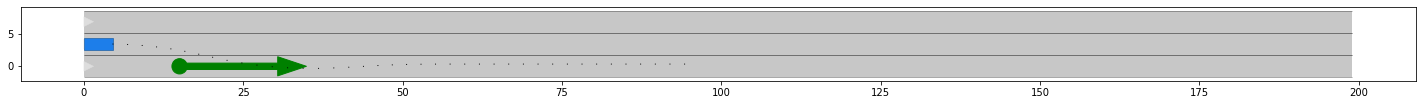

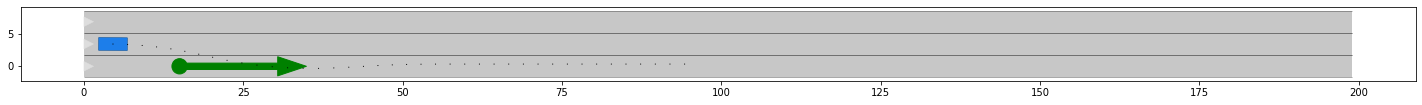

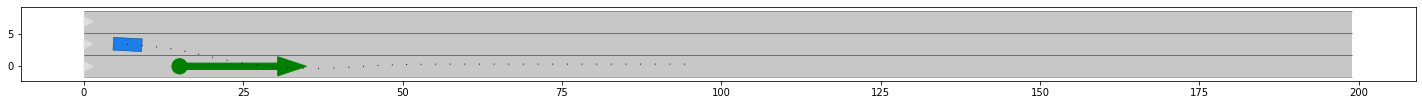

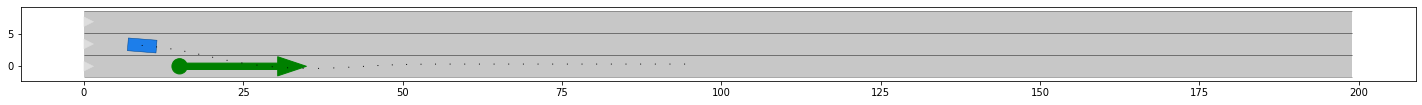

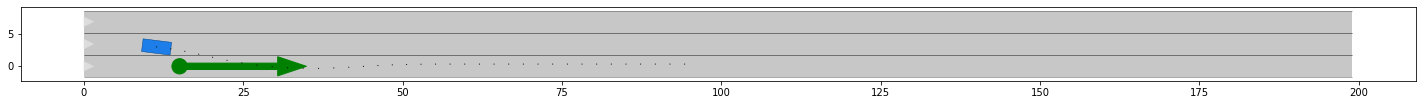

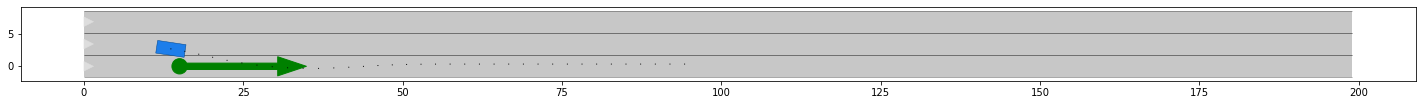

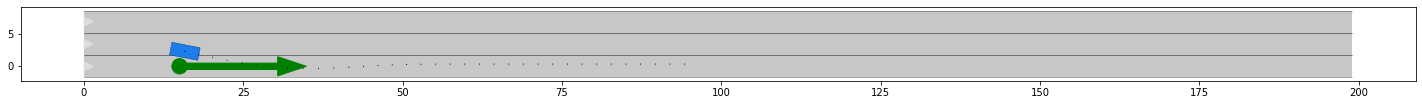

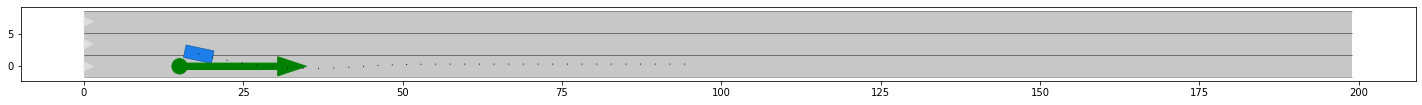

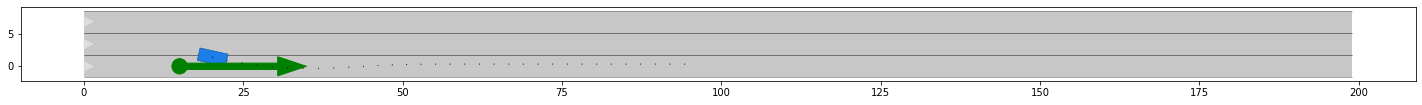

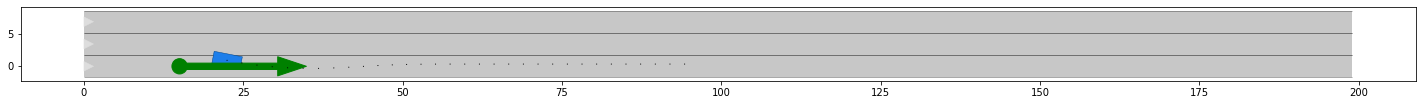

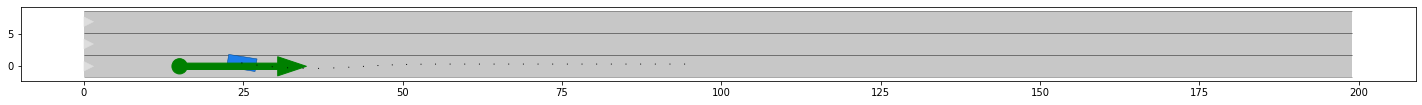

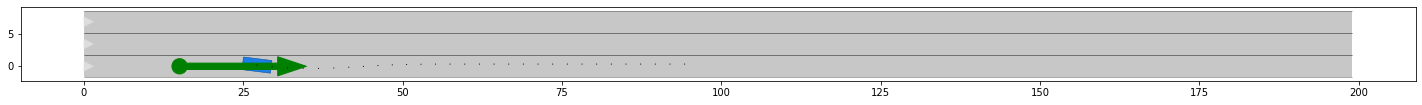

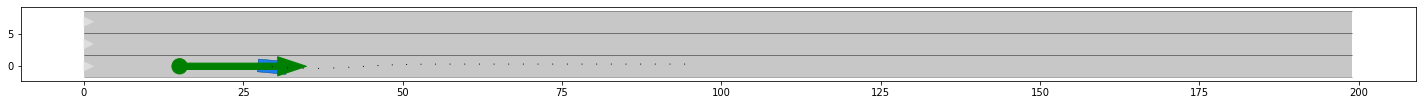

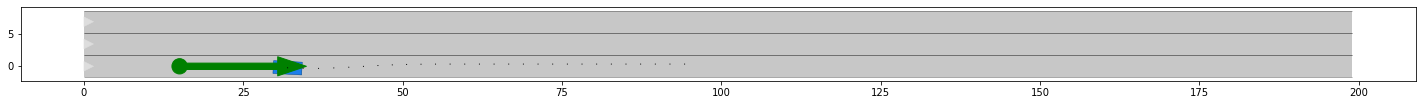

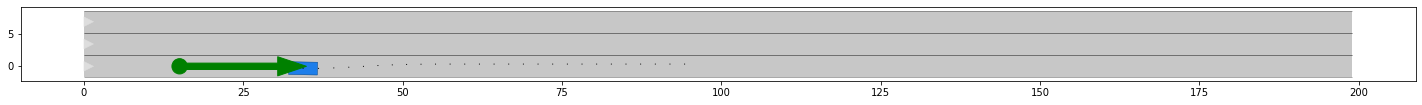

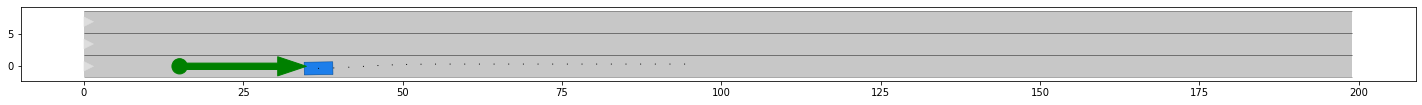

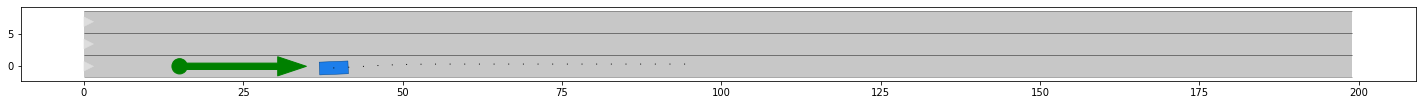

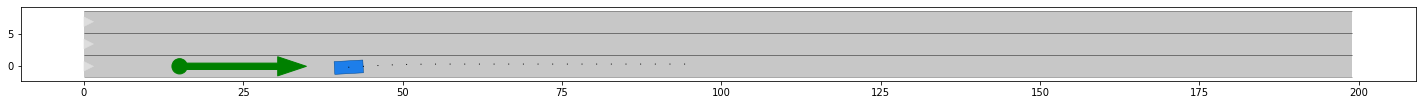

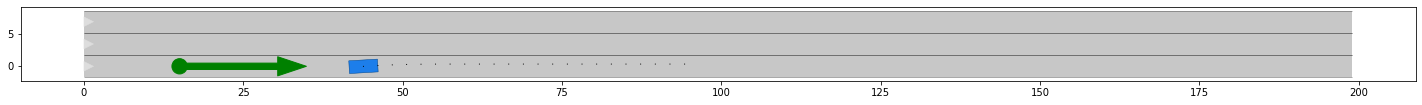

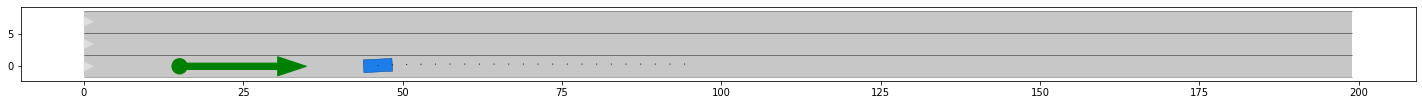

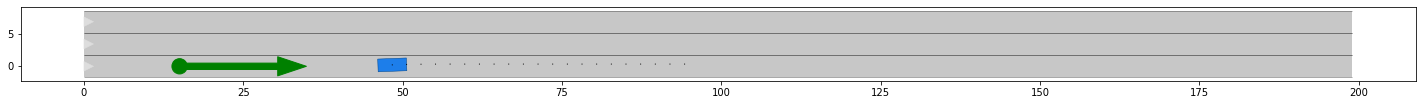

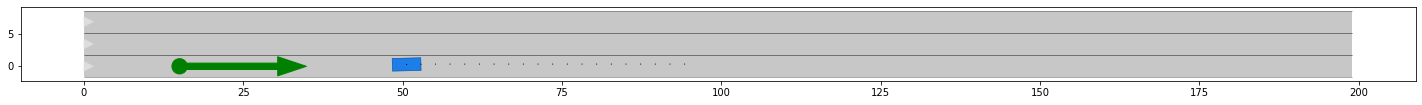

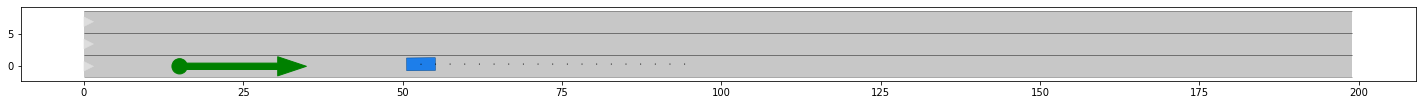

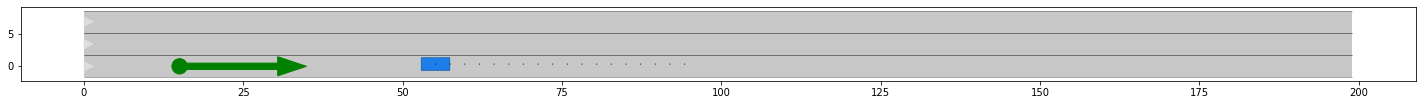

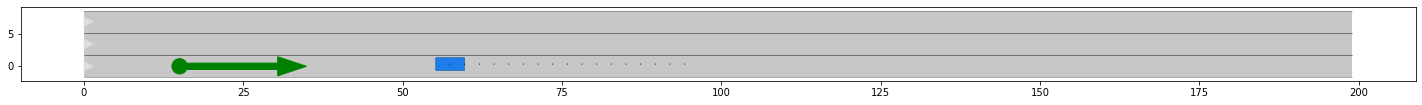

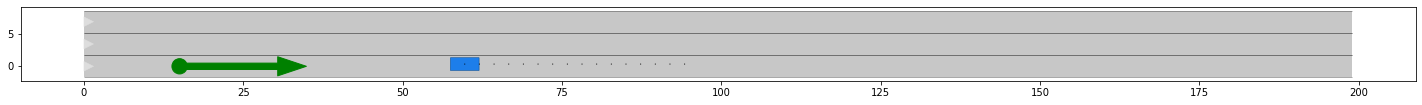

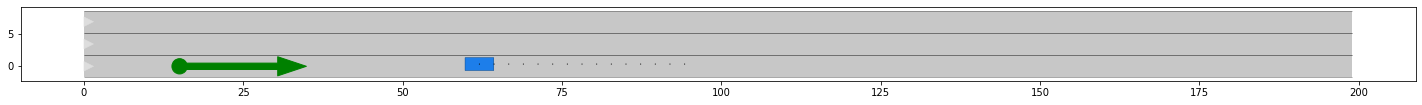

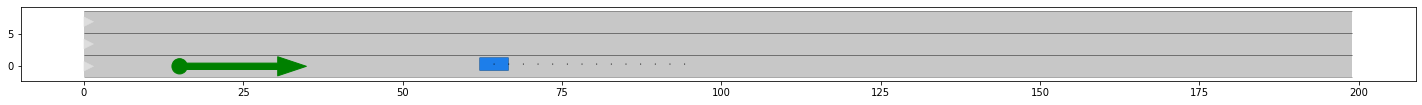

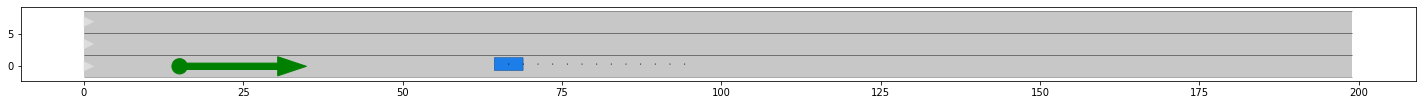

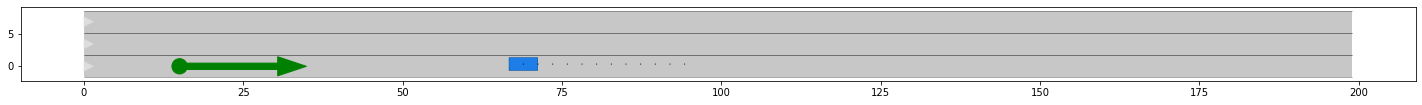

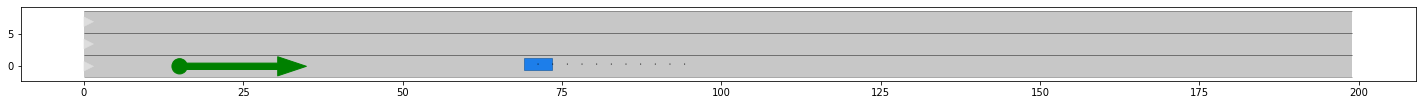

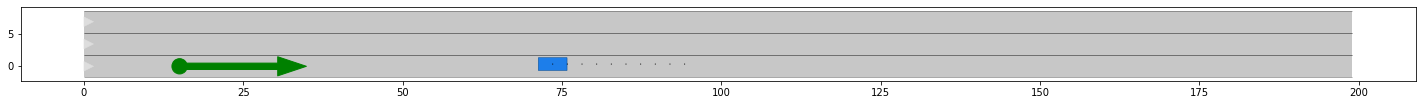

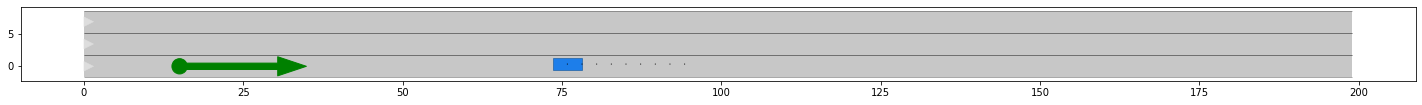

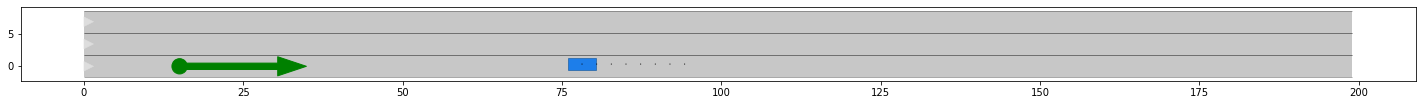

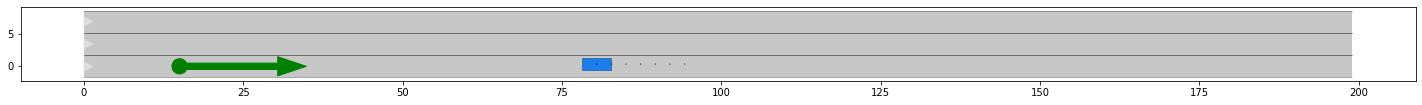

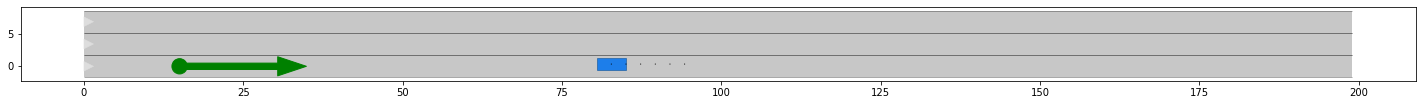

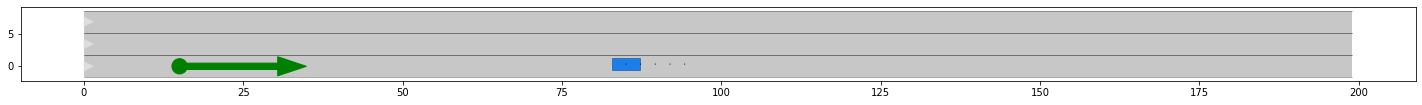

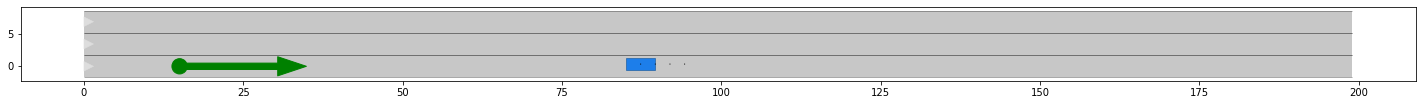

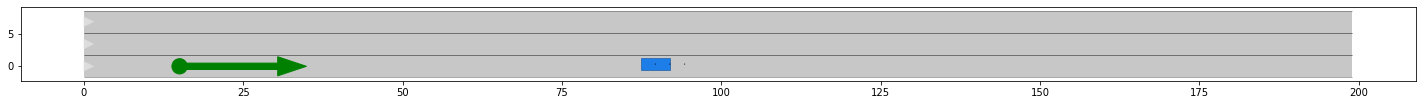

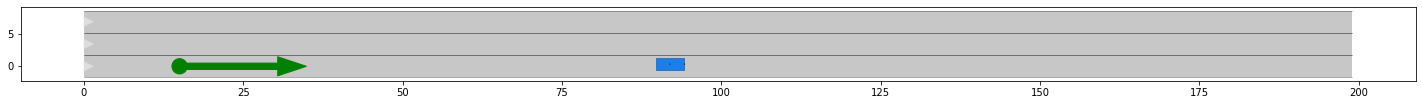

In [1]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import clear_output

# import classes and functions for reading xml file and visualizing commonroad objects
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.mp_renderer import MPRenderer

# generate path of the file to be read
path_file = "../../scenarios/tutorial/ZAM_Tutorial-1_2_T-1.xml"

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_file).open()

# plot the scenario for 40 time steps, here each time step corresponds to 0.1 second
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    renderer = MPRenderer()
    
    # uncomment the following line to visualize with animation
#     clear_output(wait=True)
    
    # plot the scenario for each time step
    scenario.draw(renderer, draw_params={'time_begin': i})
    
    # plot the planning problem set
    planning_problem_set.draw(renderer)
    
    renderer.render()
    plt.show()

## 2. Modify XML file

It is possible to modify existing CommonRoad scenarios to costumize them to one's needs. Here as an example, we would like to add a static obstacle to the scenario with the following specification:
   * obstacle type: parked vehicle
   * obstacle shape: rectangle with a width of 2.0 m and a length of 4.5 m
   * initial state:
        * position: (30, 3.5) m
        * orientation: 0.02 rad
   * obstacle id: since every object in the scenario must have a unique ID, we use the member function **generate_object_id()** of **Scenario** class to generate a unique ID for the object.

As documented in [StaticObstacle](https://commonroad-io.readthedocs.io/en/latest/api/scenario/#commonroad.scenario.obstacle.StaticObstacle), we need to provide `obstacle_id, obstacle_type, obstacle_shape, initial_state` to construct a static obstacle.

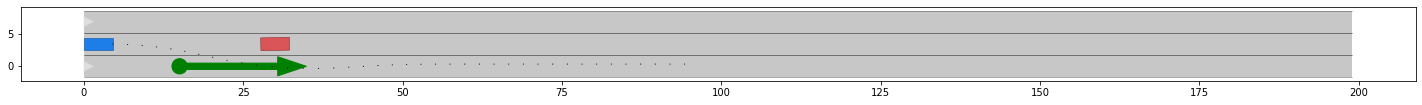

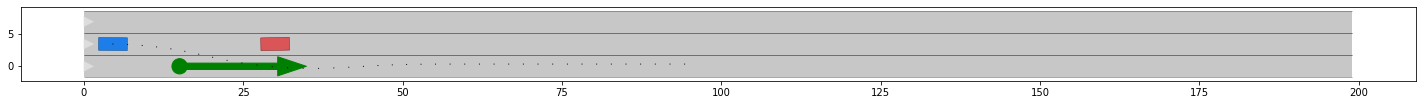

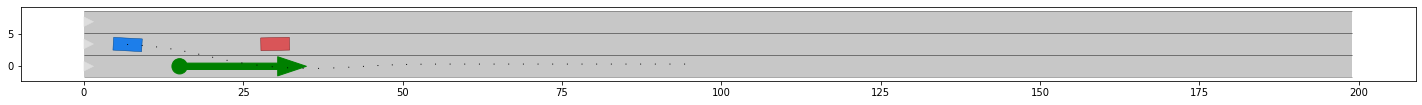

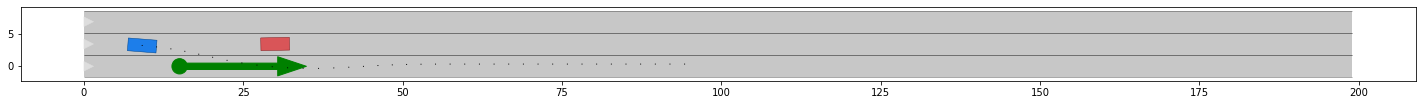

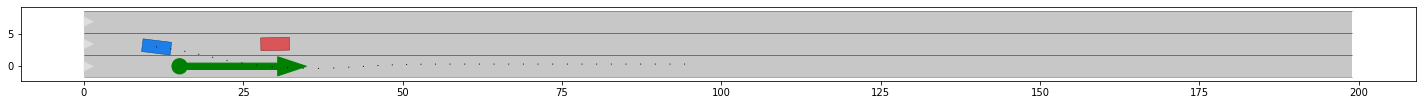

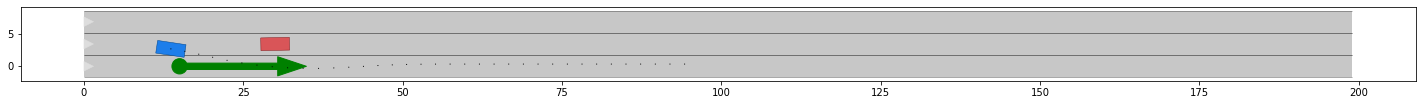

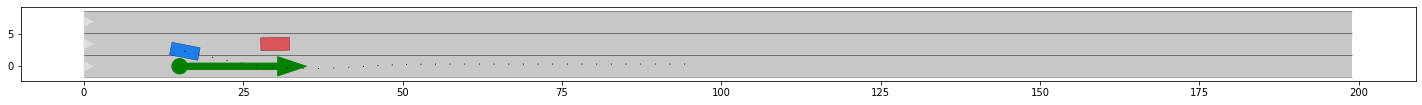

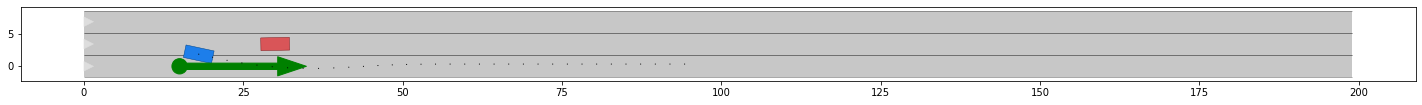

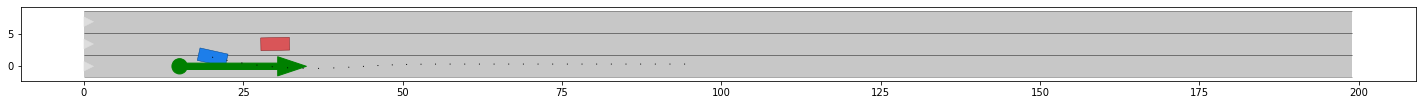

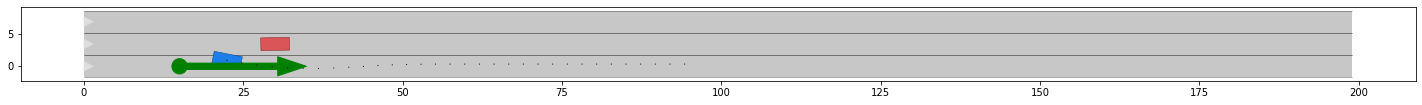

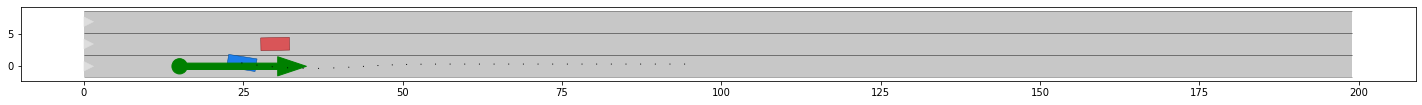

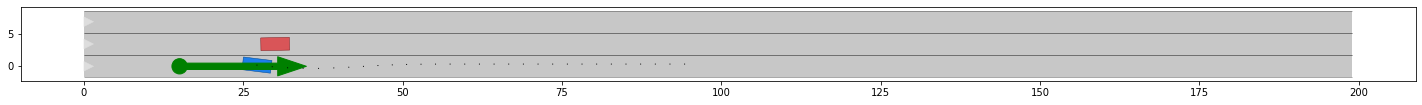

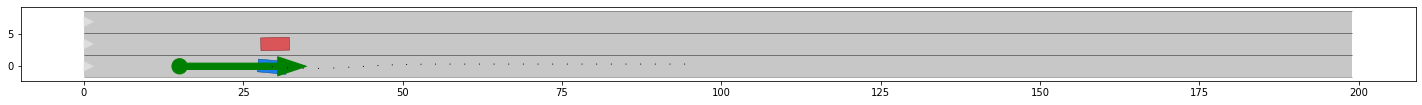

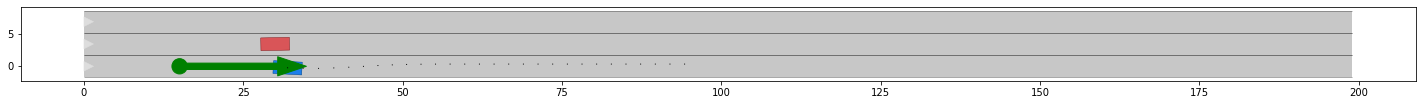

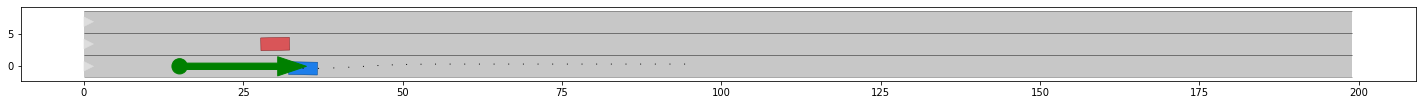

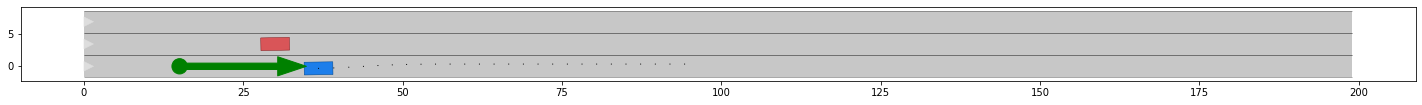

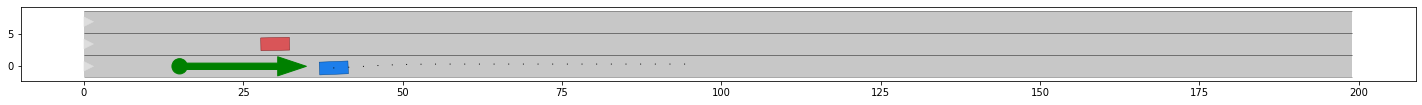

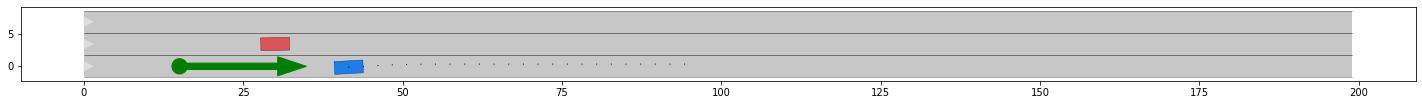

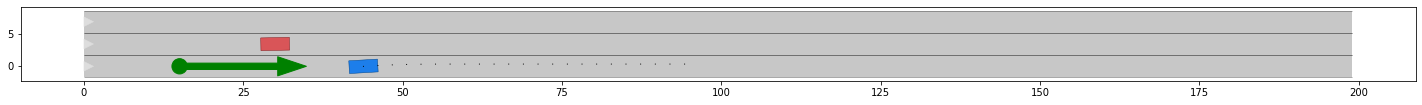

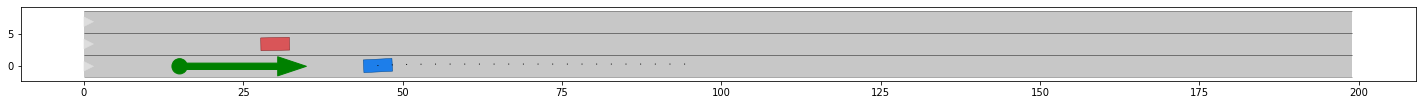

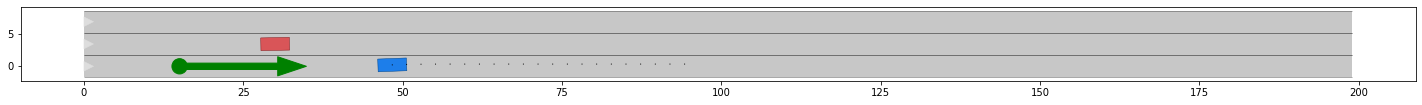

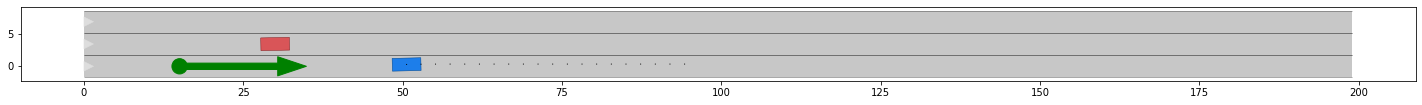

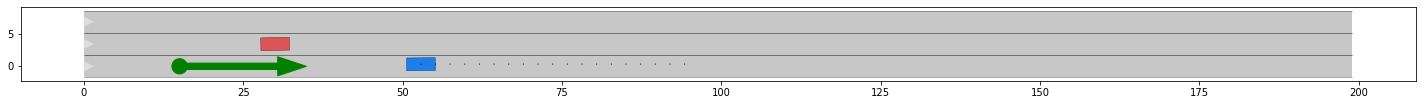

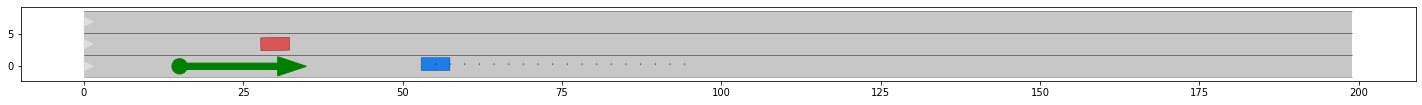

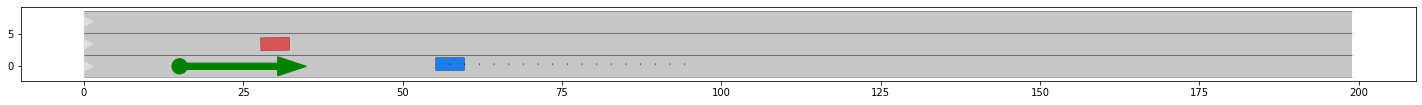

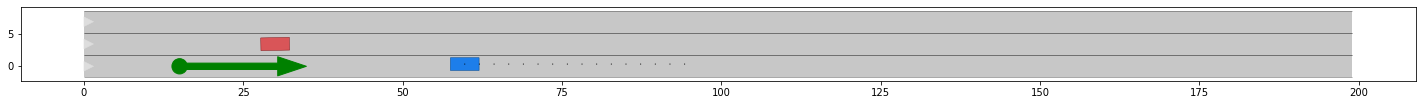

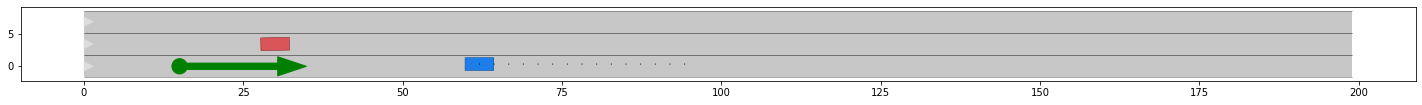

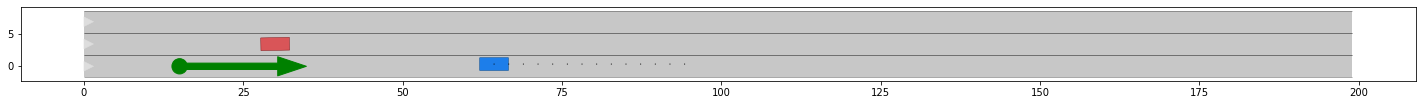

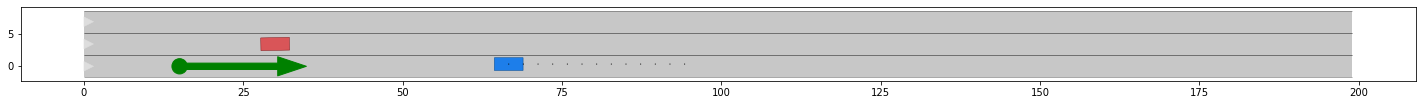

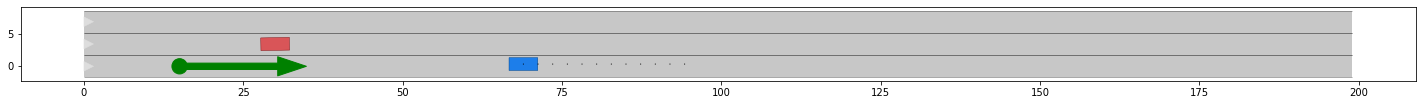

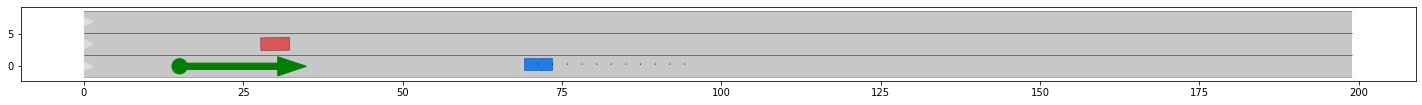

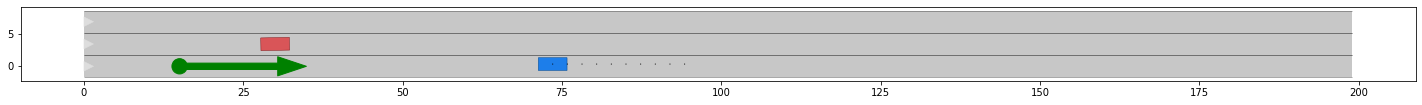

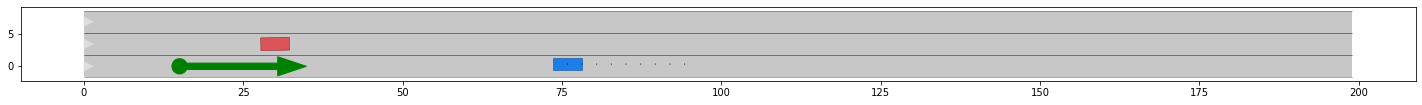

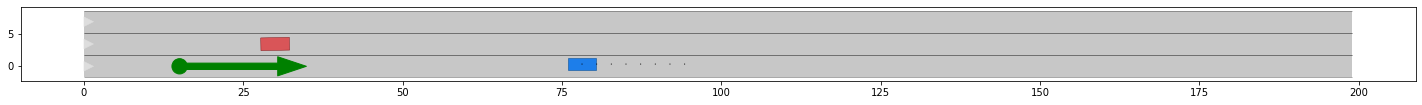

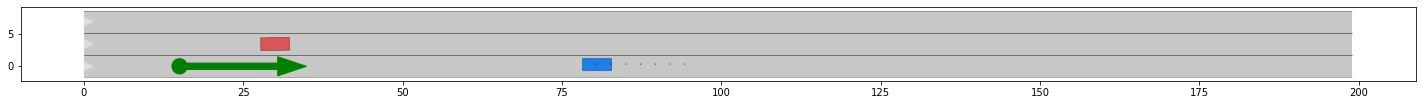

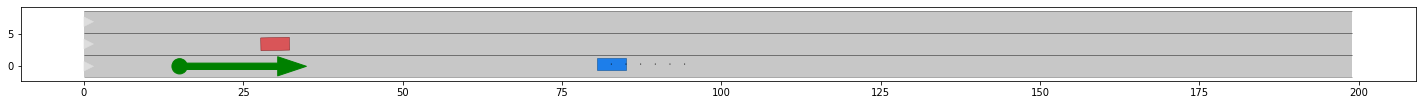

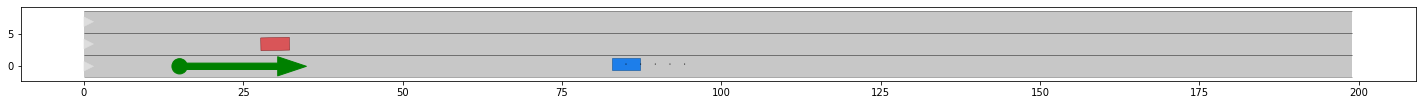

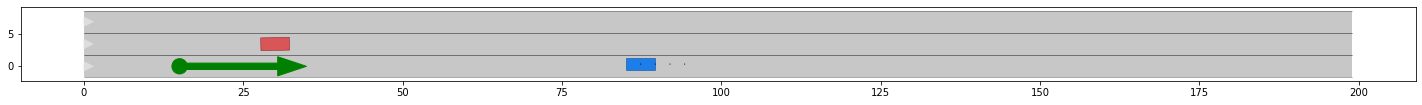

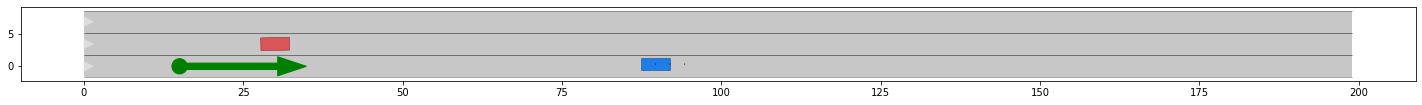

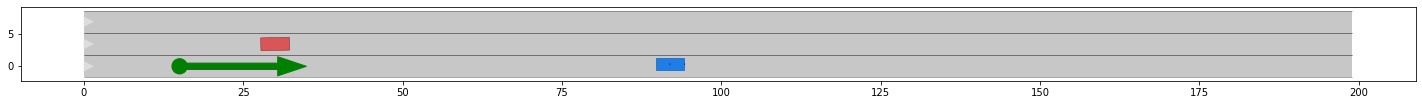

In [2]:
import numpy as np

# import necesary classes from different modules
from commonroad.geometry.shape import Rectangle
from commonroad.scenario.obstacle import StaticObstacle, ObstacleType
from commonroad.scenario.trajectory import State

# read in the scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_file).open()

# generate the static obstacle according to the specification, 
# refer to API for details of input parameters
static_obstacle_id = scenario.generate_object_id()
static_obstacle_type = ObstacleType.PARKED_VEHICLE
static_obstacle_shape = Rectangle(width = 2.0, length = 4.5)
static_obstacle_initial_state = State(position = np.array([30.0, 3.5]), 
                                      orientation = 0.02, time_step = 0)

# feed in the required components to construct a static obstacle
static_obstacle = StaticObstacle(static_obstacle_id, static_obstacle_type, 
                                 static_obstacle_shape, static_obstacle_initial_state)

# add the static obstacle to the scenario
scenario.add_objects(static_obstacle)
    
# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    renderer = MPRenderer()
    
    # uncomment the following line to visualize with animation
#     clear_output(wait=True)
    
    # plot the scenario for each time step
    scenario.draw(renderer, draw_params={'time_begin': i})
    
    # plot the planning problem set
    planning_problem_set.draw(renderer)
    
    renderer.render()
    plt.show()

As can be seen from the output, we have successfully added a new static obstacle to the scenario. We further add a dynamic obstacle with the following specifications:

   * obstacle type: car
   * obstacle shape: rectangle with a width of 1.8 m and a length of 4.3 m
   * initial state:
        * position: (50, 0.0) m
        * orientation: 0.00 rad
        * velocity: 22 m/s in the positive direction of x-axis
   * we assume that the dynamic obstacle drives with constant velocity.

As documented in [DynamicObstacle](https://commonroad-io.readthedocs.io/en/latest/api/scenario/#commonroad.scenario.obstacle.DynamicObstacle), we need to pass in a **Prediction** object, which in this case is a **TrajectoryPrediction** object. Generation of the trajectory prediction goes as follows:
   1. compute all subsequent states of the dynamic obstacle
   2. create a **Trajectory** object from these states
   3. create a **TrajectoryPrediction** object from this **Trajectory** and the shape of the dynamic obstacle

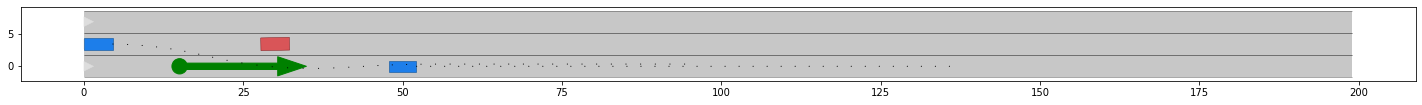

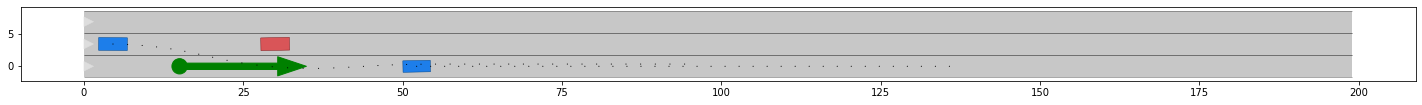

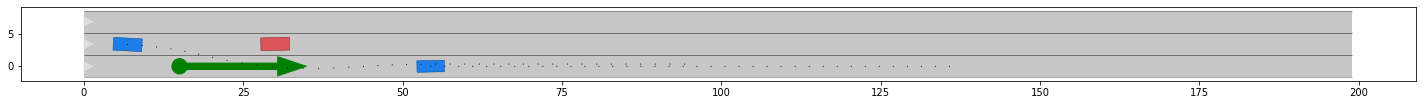

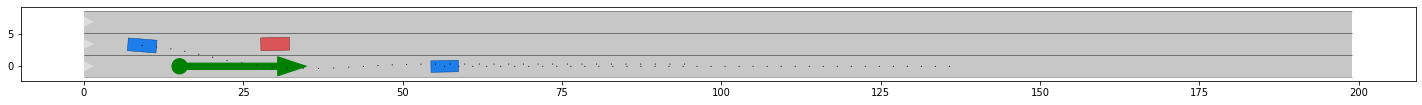

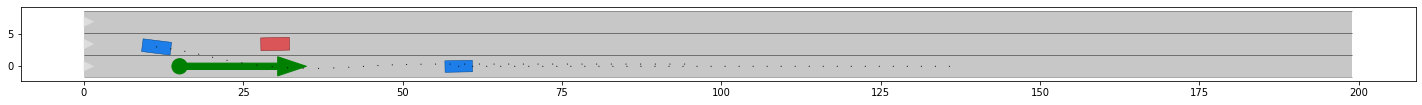

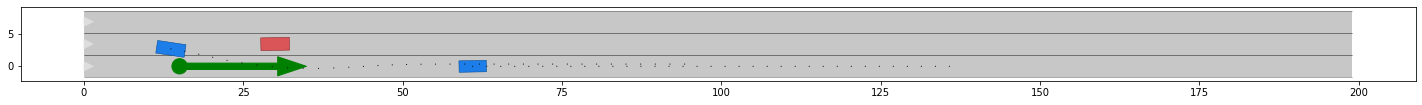

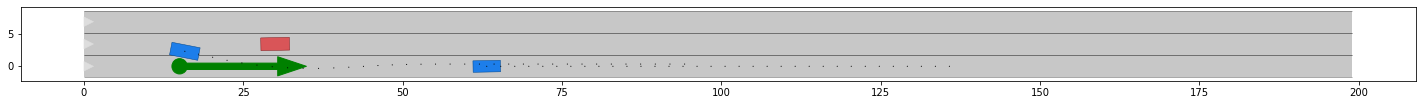

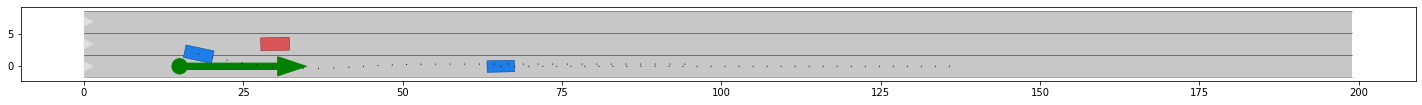

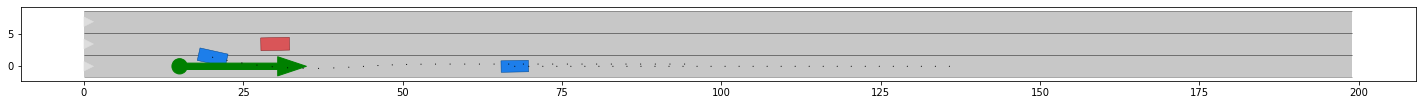

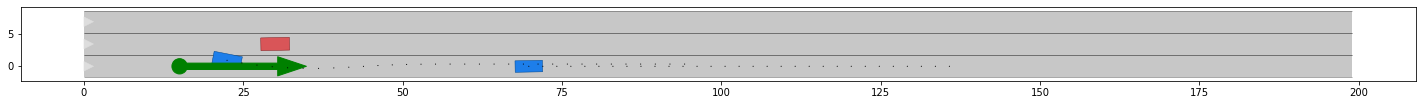

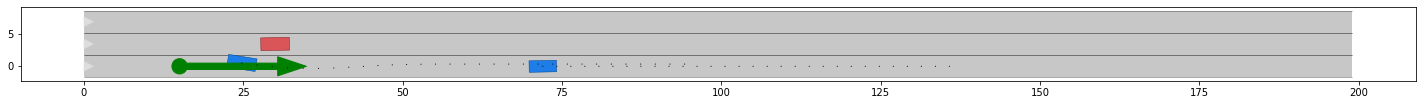

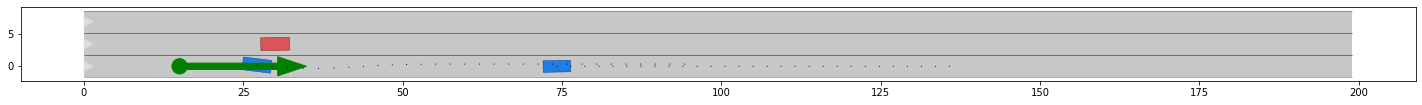

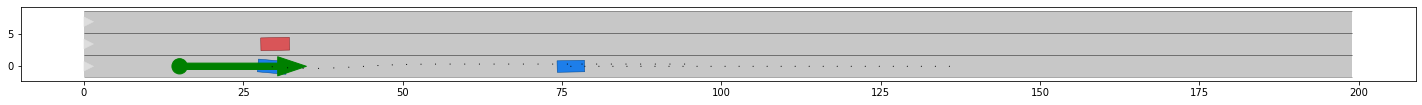

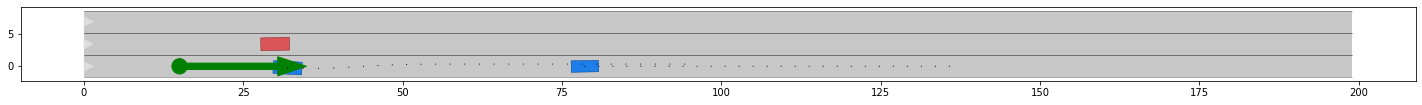

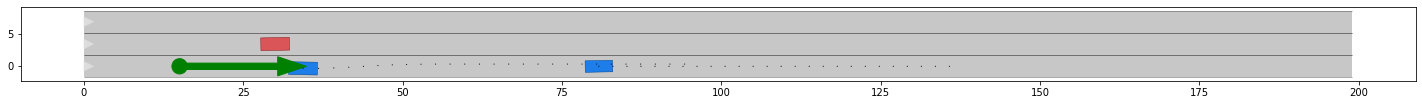

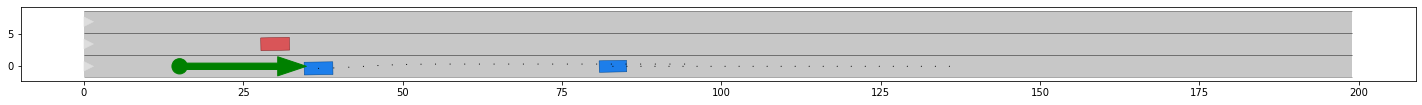

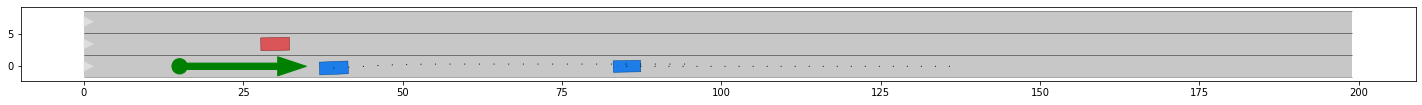

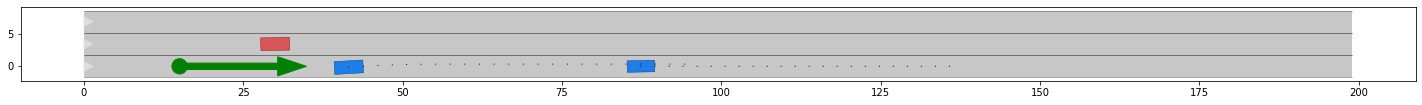

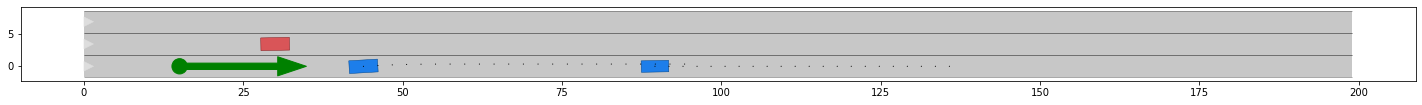

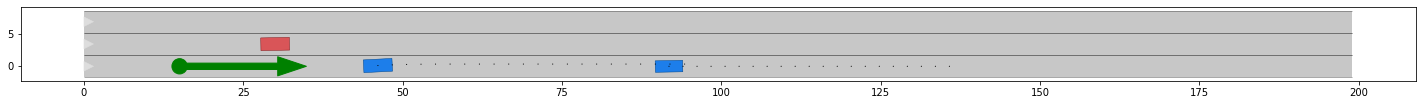

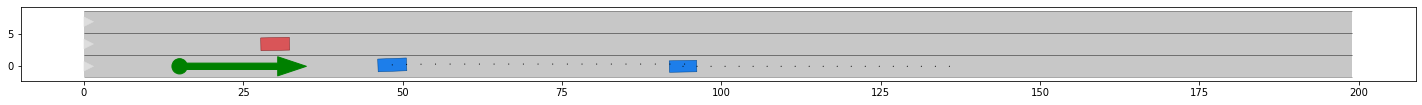

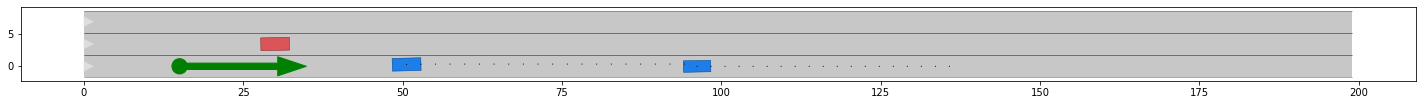

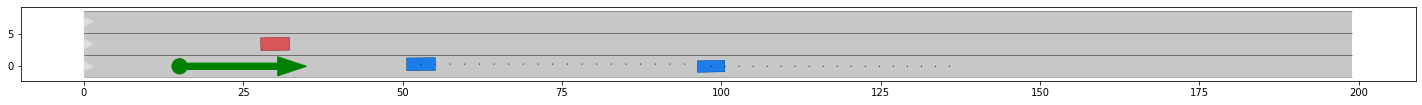

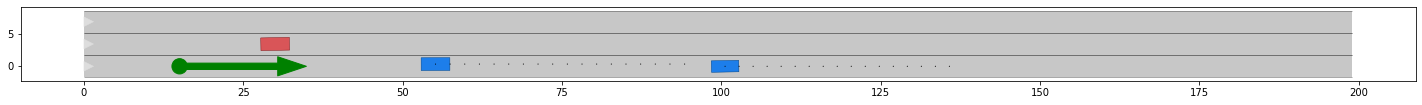

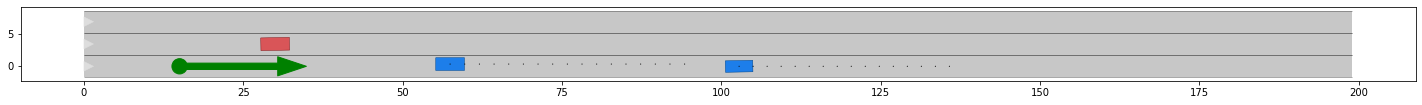

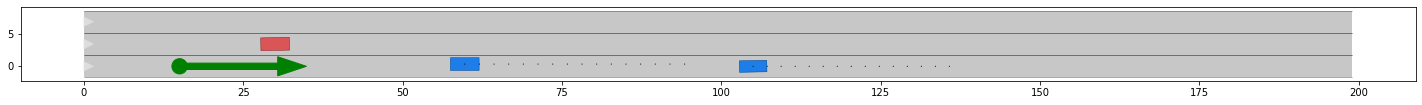

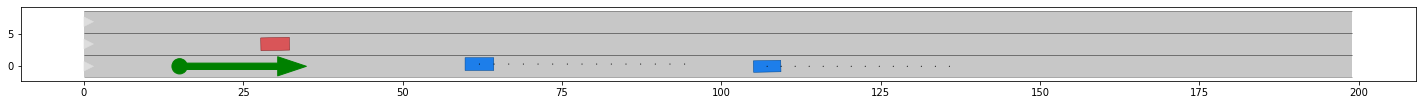

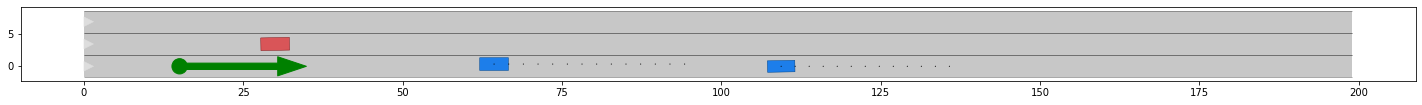

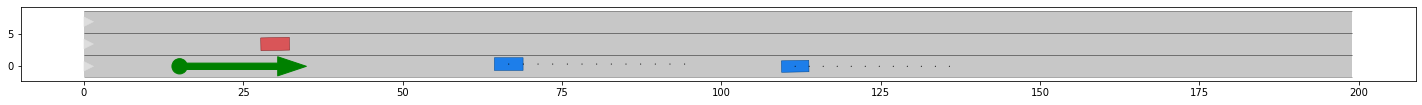

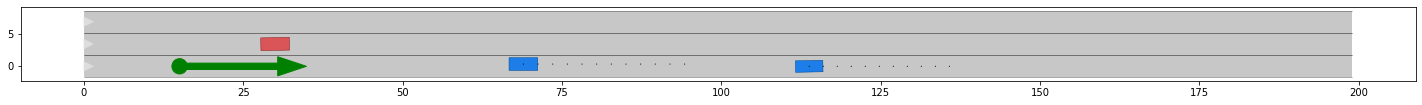

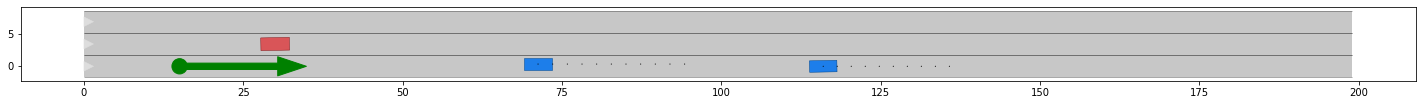

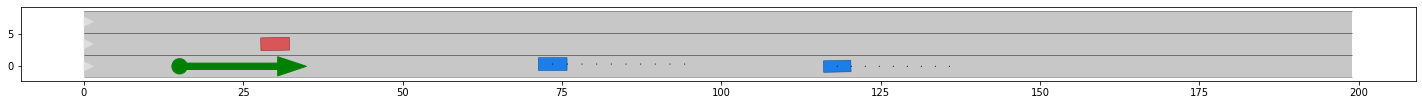

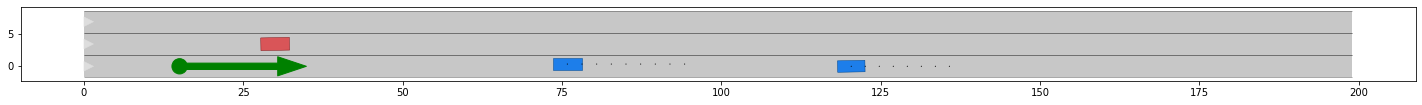

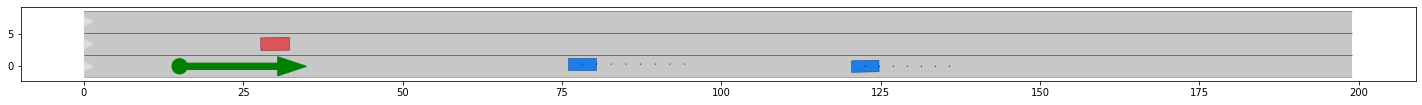

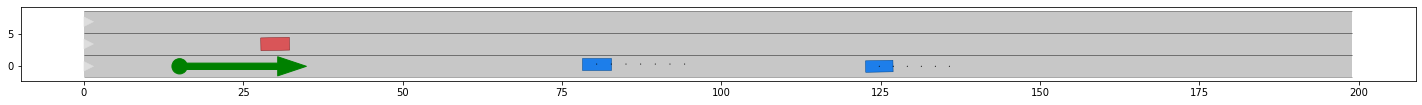

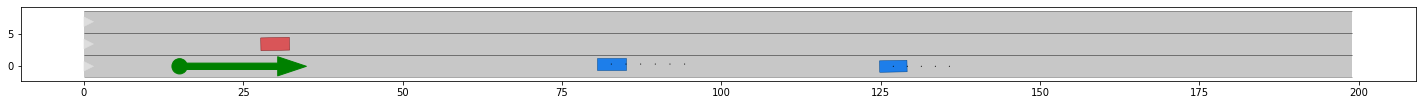

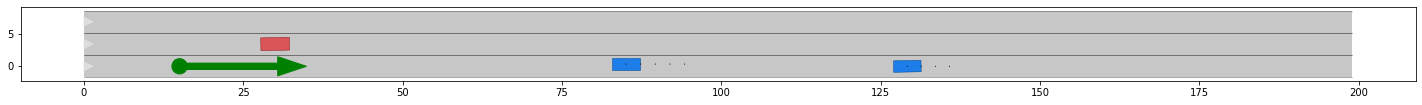

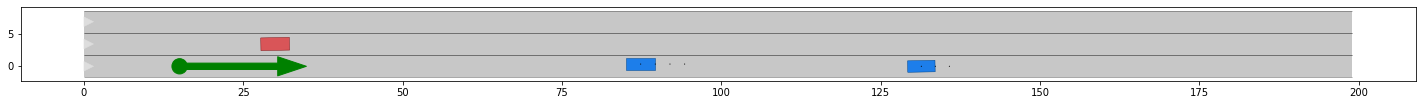

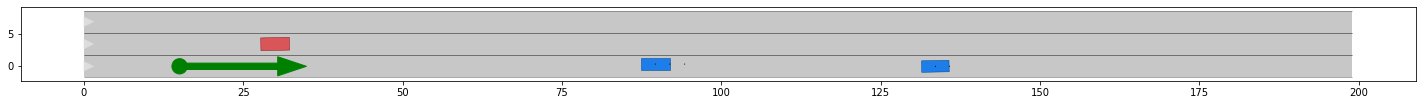

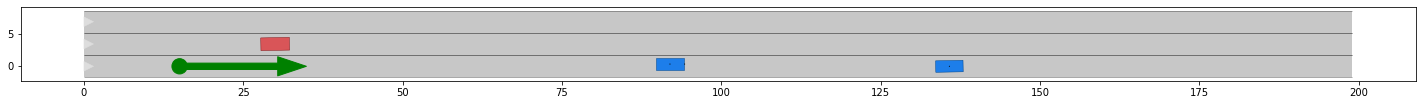

In [3]:
# import necesary classes from different modules
from commonroad.scenario.obstacle import DynamicObstacle
from commonroad.scenario.trajectory import Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction

dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
constant_velocity = 22
# initial state has a time step of 0
dynamic_obstacle_initial_state = State(position = np.array([50.0, 0.0]), 
                                       velocity = constant_velocity,
                                       orientation = 0.0, 
                                       time_step = 0)

# generate the states of the obstacle for time steps 1 to 40
state_list = []
for i in range(1, 40):
    # compute new position, here scenario.dt = 0.1 s
    new_position = np.array([dynamic_obstacle_initial_state.position[0] + 
                             scenario.dt * i * constant_velocity, 0])
    # create new state
    new_state = State(position = new_position, velocity = constant_velocity,
                      orientation = 0.02, time_step = i)
    # add new state to state_list
    state_list.append(new_state)

# create the trajectory of the obstacle starting at time step 1
dynamic_obstacle_trajectory = Trajectory(1, state_list)

# create the prediction using the trajectory and the shape of the obstacle
dynamic_obstacle_shape = Rectangle(width = 1.8, length = 4.3)
dynamic_obstacle_prediction = TrajectoryPrediction(dynamic_obstacle_trajectory, 
                                                   dynamic_obstacle_shape)

# generate the dynamic obstacle according to the specification
dynamic_obstacle_id = scenario.generate_object_id()
dynamic_obstacle_type = ObstacleType.CAR
dynamic_obstacle = DynamicObstacle(dynamic_obstacle_id, 
                                   dynamic_obstacle_type, 
                                   dynamic_obstacle_shape, 
                                   dynamic_obstacle_initial_state, 
                                   dynamic_obstacle_prediction)

# add dynamic obstacle to the scenario
scenario.add_objects(dynamic_obstacle)

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    renderer = MPRenderer()
    
    # uncomment the following line to visualize with animation
#     clear_output(wait=True)
    
    # plot the scenario for each time step
    scenario.draw(renderer, draw_params={'time_begin': i})
    
    # plot the planning problem set
    planning_problem_set.draw(renderer)
    
    renderer.render()
    plt.show()

## 3. Write XML file
After we have modified the scenario, we would like to save the changes and write the **Scenario** and **PlanningProblemSet** to a CommonRoad XML file. [CommonRoadFileWriter](https://commonroad-io.readthedocs.io/en/latest/api/common/#module-commonroad.common.file_writer) helps us to achieve this. The scenarios can be labeled with different [tags](https://commonroad-io.readthedocs.io/en/latest/_modules/commonroad/scenario/scenario/#Tag) describing them.
Note that we did not modify the **PlanningProblemSet** in this tutorial.

In [4]:
# import necesary classes from different modules
from commonroad.common.file_writer import CommonRoadFileWriter
from commonroad.common.file_writer import OverwriteExistingFile
from commonroad.scenario.scenario import Location
from commonroad.scenario.scenario import Tag

author = 'Max Mustermann'
affiliation = 'Technical University of Munich, Germany'
# where the scenario came from
source = ''
# tags of the sceanrio
tags = {Tag.CRITICAL, Tag.INTERSTATE}

# create a CommonRoad file writer
fw = CommonRoadFileWriter(scenario, planning_problem_set, author, affiliation, source, tags)

# write the scenario to the current directory (where this Jupyter Notebook is located)
name_file = "../../scenarios/tutorial/ZAM_Tutorial-1_2_T-2.xml"
fw.write_to_file(name_file, OverwriteExistingFile.ALWAYS)

We can open our saved file again to check if everything is correct:

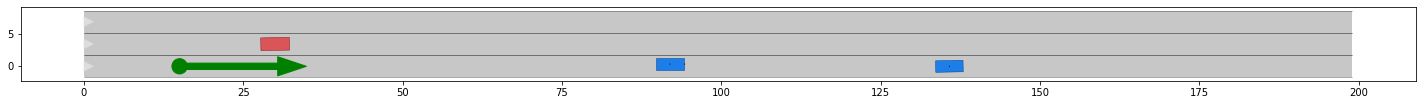

In [5]:
path_file = "../../scenarios/tutorial/ZAM_Tutorial-1_2_T-2.xml"

scenario, planning_problem_set = CommonRoadFileReader(path_file).open()

# plot the scenario for each time step
for i in range(0, 40):
    plt.figure(figsize=(25, 10))
    renderer = MPRenderer()
    
    # uncomment the following line to visualize with animation
    clear_output(wait=True)
    
    # plot the scenario for each time step
    scenario.draw(renderer, draw_params={'time_begin': i})
    
    # plot the planning problem set
    planning_problem_set.draw(renderer)
    
    renderer.render()
    plt.show()